<a href="https://colab.research.google.com/github/marcvonrohr/DeepLearning/blob/main/meta_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import json
import random
from google.colab import drive

#################################################################
#  STEP 2.1: PREPARE LOCAL VM
#################################################################

# --- 1. Mount Google Drive ---
print("Connecting Google Drive...")
drive.mount('/content/drive')
print("...Google Drive connected.")

# --- 2. Define Key Paths ---
GDRIVE_ROOT = '/content/drive/MyDrive/'
PROJECT_DIR = os.path.join(GDRIVE_ROOT, 'Deep Learning')
DATASETS_ROOT_DIR = os.path.join(PROJECT_DIR, 'datasets')
INAT_ROOT_DIR = os.path.join(DATASETS_ROOT_DIR, 'inaturalist')

# Source: The COMPRESSED archives
ARCHIVES_DIR_ON_DRIVE = os.path.join(INAT_ROOT_DIR, 'archives')

# Target: The LOCAL VM fast disk
LOCAL_DATA_ROOT = '/content/data'
# This is the final path your PyTorch code will use:
FINAL_DATA_PATH = os.path.join(LOCAL_DATA_ROOT, 'inaturalist_unpacked')

# Define source/destination paths
TAR_FILES = {
    "2021_train_mini": {
        "src": os.path.join(ARCHIVES_DIR_ON_DRIVE, '2021_train_mini.tar.gz'),
        "dest_tar": os.path.join(LOCAL_DATA_ROOT, '2021_train_mini.tar.gz'),
        "check_unpacked": os.path.join(FINAL_DATA_PATH, '2021_train_mini')
    },
    "2021_valid": {
        "src": os.path.join(ARCHIVES_DIR_ON_DRIVE, '2021_valid.tar.gz'),
        "dest_tar": os.path.join(LOCAL_DATA_ROOT, '2021_valid.tar.gz'),
        "check_unpacked": os.path.join(FINAL_DATA_PATH, '2021_valid')
    }
}

# --- 3. Create Local Directories on VM ---
os.makedirs(LOCAL_DATA_ROOT, exist_ok=True)
os.makedirs(FINAL_DATA_PATH, exist_ok=True)
print(f"Local data directory created at: {FINAL_DATA_PATH}")

# --- 4. Copy, Unpack, and Clean up for each file ---
for name, paths in TAR_FILES.items():
    print(f"\n--- Processing {name} ---")

    if os.path.exists(paths["check_unpacked"]):
        print(f"'{name}' is already unpacked in local VM. Skipping.")
        continue

    # 4a. Copy .tar.gz from Drive to local VM
    print(f"Copying '{name}.tar.gz' from Drive to local VM...")
    start_time = time.time()
    !cp "{paths['src']}" "{paths['dest_tar']}"
    print(f"...Copy complete. Took {time.time() - start_time:.2f} seconds.")

    # 4b. Unpack the file on the local VM
    print(f"Unpacking '{name}.tar.gz' locally...")
    start_time = time.time()
    !tar -xzf "{paths['dest_tar']}" -C "{FINAL_DATA_PATH}"
    print(f"...Unpacking complete. Took {time.time() - start_time:.2f} seconds.")

    # 4c. Delete the local .tar.gz file to save VM space
    print(f"Deleting local tarball '{paths['dest_tar']}'...")
    !rm "{paths['dest_tar']}"
    print("...Local tarball deleted.")

# --- 5. Verify and Set Path for Training ---
print("\n--- Final Data Setup Verification ---")
print(f"Dataset is ready for training at: {FINAL_DATA_PATH}")
!ls -lh "{FINAL_DATA_PATH}"
print("\nLocal VM Disk Space Usage:")
!df -h

Connecting Google Drive...
Mounted at /content/drive
...Google Drive connected.
Local data directory created at: /content/data/inaturalist_unpacked

--- Processing 2021_train_mini ---
Copying '2021_train_mini.tar.gz' from Drive to local VM...
...Copy complete. Took 927.91 seconds.
Unpacking '2021_train_mini.tar.gz' locally...
...Unpacking complete. Took 438.16 seconds.
Deleting local tarball '/content/data/2021_train_mini.tar.gz'...
...Local tarball deleted.

--- Processing 2021_valid ---
Copying '2021_valid.tar.gz' from Drive to local VM...
...Copy complete. Took 204.09 seconds.
Unpacking '2021_valid.tar.gz' locally...
...Unpacking complete. Took 77.49 seconds.
Deleting local tarball '/content/data/2021_valid.tar.gz'...
...Local tarball deleted.

--- Final Data Setup Verification ---
Dataset is ready for training at: /content/data/inaturalist_unpacked
total 2.5M
drwxrwxr-x 10002 1000 1000 1.3M Oct 13  2020 train_mini
drwxrwxr-x 10002 1000 1000 1.3M Oct 13  2020 val

Local VM Disk Spac

In [2]:
#################################################################
#  STEP 2.2: SCIENTIFIC DATA PARTITIONING
#################################################################
print("\n--- STEP 2.2: Loading/Creating Scientific Class Partition ---")

# --- 6. Define Paths for Partition File ---
# We create a 'project_meta' folder on GDrive to store helper files
META_DIR_ON_DRIVE = os.path.join(PROJECT_DIR, 'project_meta')
os.makedirs(META_DIR_ON_DRIVE, exist_ok=True)

PARTITION_FILE_PATH = os.path.join(META_DIR_ON_DRIVE, 'inat_class_split.json')
print(f"Looking for partition file at: {PARTITION_FILE_PATH}")


--- STEP 2.2: Loading/Creating Scientific Class Partition ---
Looking for partition file at: /content/drive/MyDrive/Deep Learning/project_meta/inat_class_split.json


In [3]:
# --- 7. Logic to Find Classes and Create Partition ---

# 7a. Identify the Dataset Root
# The unpacking might have created a subfolder (e.g., '2021_train_mini' or 'train_mini')
# or files might be directly in FINAL_DATA_PATH. We check common patterns.
possible_roots = [
    os.path.join(FINAL_DATA_PATH, '2021_train_mini'),
    os.path.join(FINAL_DATA_PATH, 'train_mini'),
    FINAL_DATA_PATH
]

DATASET_ROOT = None
for path in possible_roots:
    if os.path.exists(path):
        # Check if this path actually contains subdirectories
        if len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]) > 0:
            DATASET_ROOT = path
            break

print(f"Dataset root identified as: {DATASET_ROOT}")

# 7b. Load or Create the Partition
partition_data = {}
RANDOM_SEED = 42

if os.path.exists(PARTITION_FILE_PATH):
    print("Found existing partition file. Loading...")
    with open(PARTITION_FILE_PATH, 'r') as f:
        partition_data = json.load(f)
else:
    print("No partition file found. Scanning directories to create new partition...")
    print("This ensures independence from missing metadata files.")

    # --- Scan for Class Folders ---
    class_folders_rel = []

    # Walk through the directory tree
    # A "class" is any folder that contains image files (.jpg, .jpeg, .png)
    print("Scanning folders (this may take 1-2 minutes)...")
    for root, dirs, files in os.walk(DATASET_ROOT):
        # Check for images in this specific folder
        images = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if len(images) > 0:
            # Get path relative to the dataset root (e.g., "Aves/Turdus_migratorius")
            rel_path = os.path.relpath(root, DATASET_ROOT)
            class_folders_rel.append(rel_path)

    # --- CRITICAL: Sort for Reproducibility ---
    # Sorting ensures that Index 0 is ALWAYS the same class on every machine/run
    class_folders_rel.sort()

    num_classes = len(class_folders_rel)
    print(f"Found {num_classes} classes containing images.")

    if num_classes < 9900:
        print("WARNING: Found significantly fewer than 10,000 classes. Check extraction.")

    # --- Assign IDs and Shuffle ---
    all_class_ids = list(range(num_classes))

    print(f"Shuffling {num_classes} class IDs with random seed {RANDOM_SEED}...")
    random.seed(RANDOM_SEED)
    random.shuffle(all_class_ids)

    # --- Split into Sets ---
    # 6000 Base (Train/Meta-Train), 2000 Val (Hyperparams), 2000 Novel (Test)
    c_base_ids = all_class_ids[:6000]
    c_val_ids = all_class_ids[6000:8000]
    c_novel_ids = all_class_ids[8000:]

    # --- Construct Data Structure ---
    # We save both the sets AND the mapping from ID -> Folder Path
    partition_data = {
        "sets": {
            'c_base': sorted(c_base_ids),
            'c_val': sorted(c_val_ids),
            'c_novel': sorted(c_novel_ids)
        },
        "id_to_path": {
            str(i): folder_path for i, folder_path in enumerate(class_folders_rel)
        }
    }

    # --- Save to Drive ---
    print(f"Saving new partition and mapping to: {PARTITION_FILE_PATH}")
    with open(PARTITION_FILE_PATH, 'w') as f:
        json.dump(partition_data, f, indent=4)

Dataset root identified as: /content/data/inaturalist_unpacked/train_mini
Found existing partition file. Loading...


In [4]:
# --- 8. Verification ---
print("\n--- Partitioning Complete ---")
sets = partition_data['sets']
print(f"Total C_base classes:  {len(sets['c_base'])}")
print(f"Total C_val classes:   {len(sets['c_val'])}")
print(f"Total C_novel classes: {len(sets['c_novel'])}")

# Check for overlaps (should be 0)
base_set = set(sets['c_base'])
val_set = set(sets['c_val'])
novel_set = set(sets['c_novel'])

overlap_bv = base_set & val_set
overlap_bn = base_set & novel_set
overlap_vn = val_set & novel_set

print(f"Overlap (Base-Val):    {len(overlap_bv)}")
print(f"Overlap (Base-Novel):  {len(overlap_bn)}")
print(f"Overlap (Val-Novel):   {len(overlap_vn)}")

if len(overlap_bv) + len(overlap_bn) + len(overlap_vn) == 0:
    print("\nSUCCESS: Classes are cleanly partitioned.")
else:
    print("\nCRITICAL ERROR: Overlaps detected in class sets!")


--- Partitioning Complete ---
Total C_base classes:  6000
Total C_val classes:   2000
Total C_novel classes: 2000
Overlap (Base-Val):    0
Overlap (Base-Novel):  0
Overlap (Val-Novel):   0

SUCCESS: Classes are cleanly partitioned.


In [2]:
#################################################################
#  STEP 2.3: MODULAR DATA LOADERS (NO LEARN2LEARN DEPENDENCY)
#################################################################
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

print("\n--- STEP 2.3: Initialize Custom Data Loaders (Native PyTorch) ---")

# --- SAFETY CHECK ---
# Ensure variables from Step 2.2 exist
required_vars = ['DATASET_ROOT', 'PARTITION_FILE_PATH']
if not all(v in globals() for v in required_vars):
    raise NameError(f"Missing variables from Step 2.2. Please run the previous cell.")

print(f"Using Dataset Root: {DATASET_ROOT}")
print(f"Using Partition File: {PARTITION_FILE_PATH}")

# --- CONSTANTS ---
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]


--- STEP 2.3: Initialize Custom Data Loaders (Native PyTorch) ---


NameError: Missing variables from Step 2.2. Please run the previous cell.

In [6]:
# ==============================================================================
#  CORE COMPONENT: The Custom Dataset Class
# ==============================================================================
class MetaINatDataset(Dataset):
    """
    A custom PyTorch Dataset that enforces the scientific partition.
    """
    def __init__(self, root_dir, partition_file, split='c_base', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split

        with open(partition_file, 'r') as f:
            data = json.load(f)

        if split not in data['sets']:
            raise ValueError(f"Invalid split '{split}'. Available: {list(data['sets'].keys())}")

        self.allowed_ids = data['sets'][split]
        self.id_to_path = data['id_to_path']

        # Map original ID -> 0..N-1
        self.label_map = {orig: new for new, orig in enumerate(self.allowed_ids)}

        self.samples = []
        for original_id in self.allowed_ids:
            rel_path = self.id_to_path[str(original_id)]
            abs_path = os.path.join(self.root_dir, rel_path)
            if os.path.exists(abs_path):
                for img in os.listdir(abs_path):
                    if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.samples.append({
                            'path': os.path.join(abs_path, img),
                            'label': self.label_map[original_id]
                        })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample['path']).convert('RGB')
        label = sample['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
# ==============================================================================
#  HELPER: Episodic Batch Generator (Replaces learn2learn)
# ==============================================================================
class EpisodicTaskGenerator:
    """
    Native PyTorch implementation of an N-Way K-Shot task sampler.
    Replaces learn2learn functionality without installation issues.
    """
    def __init__(self, dataset, ways, shots, query_shots):
        self.dataset = dataset
        self.ways = ways
        self.shots = shots
        self.query_shots = query_shots

        # Group all image indices by their label for fast sampling
        self.indices_by_label = {}
        for idx, sample in enumerate(dataset.samples):
            lbl = sample['label']
            if lbl not in self.indices_by_label:
                self.indices_by_label[lbl] = []
            self.indices_by_label[lbl].append(idx)

        self.classes = list(self.indices_by_label.keys())

    def __iter__(self):
        return self

    def __next__(self):
        # 1. Sample N random classes (Ways)
        selected_classes = random.sample(self.classes, self.ways)

        batch_images = []
        batch_labels = []

        # 2. Sample K + Q images from each class
        for local_label, global_label_idx in enumerate(selected_classes):
            indices = self.indices_by_label[global_label_idx]

            # Ensure we have enough images, otherwise sample with replacement
            needed = self.shots + self.query_shots
            if len(indices) >= needed:
                selected_indices = random.sample(indices, needed)
            else:
                selected_indices = random.choices(indices, k=needed)

            # 3. Load images and re-label them to 0..N-1 for the episode
            for idx in selected_indices:
                img, _ = self.dataset[idx] # dataset returns (img, global_label)
                batch_images.append(img)
                # Important: The label for the loss function must be 0..Ways-1
                batch_labels.append(local_label)

        # Stack into a single tensor: [Ways * (Shots+Query), C, H, W]
        data = torch.stack(batch_images)
        labels = torch.tensor(batch_labels)

        return data, labels

    def sample(self):
        # Compatibility method to look like learn2learn
        return self.__next__()

In [8]:
# ==============================================================================
#  LOADER A: Standard Pre-Training Loader
# ==============================================================================
def get_standard_loader(split='c_base', batch_size=64, shuffle=True):
    print(f"\n[Loader A] Initializing Standard Loader for split '{split}'...")

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
    ])

    dataset = MetaINatDataset(DATASET_ROOT, PARTITION_FILE_PATH, split=split, transform=train_transforms)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)

    print(f" -> {len(dataset)} total images.")
    print(f" -> {len(dataset.allowed_ids)} classes.")
    return loader, len(dataset.allowed_ids)

In [9]:
# ==============================================================================
#  LOADER B: Episodic Task Loader (MAML) - NATIVE IMPLEMENTATION
# ==============================================================================
def get_episodic_taskset(split='c_base', ways=5, shots=1, query_shots=1, img_size=84):
    print(f"\n[Loader B] Initializing Episodic Generator for split '{split}'...")

    maml_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
    ])

    dataset = MetaINatDataset(DATASET_ROOT, PARTITION_FILE_PATH, split=split, transform=maml_transforms)

    # Use our native generator instead of learn2learn
    task_generator = EpisodicTaskGenerator(
        dataset,
        ways=ways,
        shots=shots,
        query_shots=query_shots
    )

    print(f" -> Configured {ways}-Way {shots}-Shot Tasks (Native PyTorch).")
    return task_generator

In [10]:
# ==============================================================================
#  LOADER C: Fixed Few-Shot Loader for FT/LoRA
# ==============================================================================
def get_fixed_few_shot_task(split='c_novel', ways=5, shots=1, query_shots=15, seed=None):
    print(f"\n[Loader C] Creating Fixed Few-Shot Task from '{split}'...")

    if seed:
        random.seed(seed)
        torch.manual_seed(seed)

    eval_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
    ])

    dataset = MetaINatDataset(DATASET_ROOT, PARTITION_FILE_PATH, split=split, transform=eval_transforms)

    available_labels = list(set(s['label'] for s in dataset.samples))
    selected_classes = random.sample(available_labels, ways)

    class_indices = {c: [] for c in selected_classes}
    for idx, sample in enumerate(dataset.samples):
        if sample['label'] in selected_classes:
            class_indices[sample['label']].append(idx)

    support_indices = []
    query_indices = []

    for c in selected_classes:
        idxs = class_indices[c]
        random.shuffle(idxs)
        support_indices.extend(idxs[:shots])
        query_indices.extend(idxs[shots : shots+query_shots])

    support_loader = DataLoader(Subset(dataset, support_indices), batch_size=16, shuffle=True)
    query_loader = DataLoader(Subset(dataset, query_indices), batch_size=32, shuffle=False)

    print(f" -> Support Set: {len(support_indices)} images, Query Set: {len(query_indices)} images")
    return support_loader, query_loader

In [11]:
# ==============================================================================
#  VERIFICATION
# ==============================================================================
print("\n--- Testing Loaders ---")

# Test A
try:
    l_std, n_cls = get_standard_loader(split='c_base', batch_size=4)
    print("Loader A (Standard) check: OK.")
except Exception as e:
    print(f"Loader A Failed: {e}")

# Test B (Now using Native Generator)
try:
    task_gen = get_episodic_taskset(split='c_base', ways=5, shots=1, query_shots=1)
    batch_data, batch_labels = task_gen.sample()
    # Expected shape: [Way*(Shot+Query), 3, 84, 84] -> [5*(1+1), 3, 84, 84] = [10, 3, 84, 84]
    print(f"Loader B (Episodic) check: OK. Batch shape: {batch_data.shape}")
    if batch_labels.max() >= 5:
        print("WARNING: Labels not properly remapped to 0..N-1")
except Exception as e:
    print(f"Loader B Failed: {e}")

# Test C
try:
    sup_dl, q_dl = get_fixed_few_shot_task(split='c_novel', ways=5, shots=5)
    print("Loader C (Fixed) check: OK.")
except Exception as e:
    print(f"Loader C Failed: {e}")

print("\nStep 2.3 Complete (Dependencies Fixed).")


--- Testing Loaders ---

[Loader A] Initializing Standard Loader for split 'c_base'...
 -> 300000 total images.
 -> 6000 classes.
Loader A (Standard) check: OK.

[Loader B] Initializing Episodic Generator for split 'c_base'...
 -> Configured 5-Way 1-Shot Tasks (Native PyTorch).
Loader B (Episodic) check: OK. Batch shape: torch.Size([10, 3, 84, 84])

[Loader C] Creating Fixed Few-Shot Task from 'c_novel'...
 -> Support Set: 25 images, Query Set: 75 images
Loader C (Fixed) check: OK.

Step 2.3 Complete (Dependencies Fixed).


In [12]:
#################################################################
#  PHASE 4: INTELLIGENT PRE-TRAINING (MAX PERF & MEMORY SAFE)
#################################################################
import os
import time
import shutil
import random
import gc  # <--- WICHTIG für Garbage Collection
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from tqdm.notebook import tqdm
from torch.cuda.amp import autocast, GradScaler
from google.colab import drive

print("\n--- PHASE 4: Pipeline 0 - Base Model Pre-Training ---")

# --- 0. DRIVE & PATH SETUP ---
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')

GDRIVE_ROOT = '/content/drive/MyDrive/'
PROJECT_DIR = os.path.join(GDRIVE_ROOT, 'Deep Learning')
MODELS_DIR = os.path.join(PROJECT_DIR, 'models', 'base_models')
os.makedirs(MODELS_DIR, exist_ok=True)

# --- 1. SEED SETUP ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# --- 2. HARDWARE DETECTION (TUNED FOR A100) ---
def get_optimal_config():
    cpu_count = os.cpu_count()
    optimal_workers = min(cpu_count, 8)
    device_name = "CPU"
    batch_size = 16

    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        device_name = gpu_name
        # --- TUNING ---
        if "A100" in gpu_name:
            batch_size = 512  # <--- Aggressiver für A100 (40GB VRAM erlaubt das locker)
        elif "T4" in gpu_name:
            batch_size = 128
        else:
            batch_size = 64
    else:
        print("WARNING: No GPU detected!")

    return device_name, batch_size, optimal_workers

detected_device, auto_bs, auto_workers = get_optimal_config()

# --- 3. CONFIGURATION ---
CONFIG = {
    'ARCH': 'resnet34',

    # --- CONTROL CENTER ---
    'DRY_RUN': False,            # <--- REAL TRAINING
    'NUM_EPOCHS': 20,
    # ----------------------

    'BATCH_SIZE': auto_bs,
    'NUM_WORKERS': auto_workers,
    'DEVICE_NAME': detected_device,
    'LEARNING_RATE': 1e-3,
    'PATIENCE': 5,
    'SUBSETS': [0.25, 0.50, 1.0],

    'CHECKPOINT_DIR_LOC': '/content/checkpoints',
    'CHECKPOINT_DIR_DRIVE': MODELS_DIR
}

os.makedirs(CONFIG['CHECKPOINT_DIR_LOC'], exist_ok=True)

print(f"\nSystem Configuration:")
print(f" -> Hardware:    {CONFIG['DEVICE_NAME']}")
print(f" -> Batch Size:  {CONFIG['BATCH_SIZE']} (Optimized)")
print(f" -> Workers:     {CONFIG['NUM_WORKERS']}")
print(f" -> Mode:        {'DRY RUN' if CONFIG['DRY_RUN'] else 'REAL TRAINING'}")

# --- 4. MEMORY CLEANUP HELPER (NEW) ---
def cleanup_memory():
    """Forces Garbage Collection and clears GPU Cache."""
    gc.collect()
    torch.cuda.empty_cache()
    # Optional: Print stats to verify
    # print(f"   [Mem] Reserved: {torch.cuda.memory_reserved(0)/1e9:.2f} GB")


# --- 5. MODEL FACTORY ---
def get_base_model(arch_name, num_classes, pretrained=True):
    # Loading logic same as before
    if arch_name == 'resnet34':
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT if pretrained else None)
        in_features = model.fc.in_features
    elif arch_name == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        in_features = model.fc.in_features
    elif arch_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
        in_features = model.fc.in_features
    else:
        raise ValueError("Arch not supported")
    model.fc = nn.Linear(in_features, num_classes)
    return model

# --- 6. DATA LOADER HELPER ---
def get_subset_loader(fraction):
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
    ])

    full_ds = MetaINatDataset(DATASET_ROOT, PARTITION_FILE_PATH, split='c_base', transform=train_transforms)

    total_base_classes = len(full_ds.allowed_ids)
    target_num = int(total_base_classes * fraction)
    subset_ids = full_ds.allowed_ids[:target_num]

    # Filter samples (Memory efficient filtering logic)
    # We recreate the list to drop references to unused samples
    new_samples = [s for s in full_ds.samples if s['label'] < target_num]
    full_ds.samples = new_samples
    full_ds.allowed_ids = subset_ids
    full_ds.label_map = {orig: new for new, orig in enumerate(subset_ids)}

    print(f"\n[Data] Subset {fraction*100}%: {len(new_samples)} images, {target_num} classes.")

    num_val = int(0.1 * len(full_ds))
    train_ds, val_ds = random_split(full_ds, [len(full_ds)-num_val, num_val],
                                    generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True,
                              num_workers=CONFIG['NUM_WORKERS'], pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False,
                            num_workers=CONFIG['NUM_WORKERS'], pin_memory=True)

    return train_loader, val_loader, target_num

# --- 7. ROBUST CHECKPOINTING ---
def safe_copy_to_drive(local_path, filename, max_retries=5):
    drive_path = os.path.join(CONFIG['CHECKPOINT_DIR_DRIVE'], filename)
    if not os.path.exists(CONFIG['CHECKPOINT_DIR_DRIVE']):
        try: os.makedirs(CONFIG['CHECKPOINT_DIR_DRIVE'], exist_ok=True)
        except: pass

    for attempt in range(1, max_retries + 1):
        try:
            shutil.copy(local_path, drive_path)
            if os.path.exists(drive_path) and os.path.getsize(drive_path) > 0:
                print(f"   -> Drive Copy: SUCCESS")
                return
        except Exception as e:
            wait_time = 3 * attempt
            print(f"   [Retry {attempt}] Copy failed ({e}). Waiting {wait_time}s...")
            time.sleep(wait_time)
    print(f"   [CRITICAL ERROR] Failed to copy {filename} to Drive.")

def save_checkpoint(state, filename):
    local_path = os.path.join(CONFIG['CHECKPOINT_DIR_LOC'], filename)
    torch.save(state, local_path)
    safe_copy_to_drive(local_path, filename)

def save_best_model(model, filename):
    local_path = os.path.join(CONFIG['CHECKPOINT_DIR_LOC'], filename)
    torch.save(model.state_dict(), local_path)
    safe_copy_to_drive(local_path, filename)

# --- 8. TRAINING ENGINE ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, target_epochs, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    scaler = GradScaler()

    run_tag = "_dryrun" if CONFIG['DRY_RUN'] else ""
    ckpt_filename = f"{model_name}{run_tag}_checkpoint.pth"
    best_filename = f"{model_name}{run_tag}_best.pth"

    start_epoch = 0
    best_acc = -1.0

    # Resume Logic
    drive_ckpt_path = os.path.join(CONFIG['CHECKPOINT_DIR_DRIVE'], ckpt_filename)
    if os.path.exists(drive_ckpt_path):
        print(f"\n[RESUME] Found: {ckpt_filename}")
        try:
            checkpoint = torch.load(drive_ckpt_path, map_location=device)
            saved_epoch = checkpoint['epoch']

            if CONFIG['DRY_RUN']:
                print(f"   -> (Dry Run) Resetting loop despite found epoch {saved_epoch+1}.")
                start_epoch = 0
                best_acc = checkpoint.get('best_acc', -1.0)
            else:
                if saved_epoch >= (target_epochs - 1):
                    print(f"   -> Fully trained ({saved_epoch+1} epochs). Skipping.")
                    return model
                start_epoch = saved_epoch + 1
                best_acc = checkpoint.get('best_acc', 0.0)

            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            if 'scaler_state_dict' in checkpoint:
                scaler.load_state_dict(checkpoint['scaler_state_dict'])
            print(f"   -> Resuming with Best Acc: {best_acc:.4f}")
        except Exception as e:
            print(f"   [ERROR] Checkpoint corrupted ({e}). Fresh start.")
    else:
        print(f"\n[START] Fresh start for {model_name}.")

    effective_epochs = 2 if CONFIG['DRY_RUN'] else target_epochs
    patience_counter = 0

    for epoch in range(start_epoch, effective_epochs):
        print(f"\nEpoch {epoch+1}/{effective_epochs}")

        model.train()
        running_loss = 0.0
        running_corrects = 0
        limit_batches = 5 if CONFIG['DRY_RUN'] else None

        pbar = tqdm(train_loader, leave=False, desc="Training")

        for i, (inputs, labels) in enumerate(pbar):
            if limit_batches and i >= limit_batches: break
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            pbar.set_postfix(loss=loss.item())

        iter_size = (limit_batches * CONFIG['BATCH_SIZE']) if limit_batches else len(train_loader.dataset)
        if iter_size == 0: iter_size = 1
        epoch_acc = running_corrects.double() / iter_size
        epoch_loss = running_loss / iter_size
        scheduler.step(epoch_loss)

        model.eval()
        val_corrects = 0
        val_limit = 5 if CONFIG['DRY_RUN'] else None
        val_count = 0
        for i, (inputs, labels) in enumerate(val_loader):
            if val_limit and i >= val_limit: break
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_count += inputs.size(0)
        val_acc = val_corrects.double() / val_count if val_count > 0 else 0.0
        print(f"   Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Save Checkpoint
        full_state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'best_acc': best_acc
        }
        save_checkpoint(full_state, ckpt_filename)

        # Save Best Model logic
        save_condition = False
        if val_acc > best_acc: save_condition = True
        elif CONFIG['DRY_RUN'] and val_acc >= best_acc: save_condition = True
        elif best_acc == -1.0: save_condition = True

        if save_condition:
            best_acc = val_acc
            save_best_model(model, best_filename)
            print(f"   [New Best] Saved {best_filename}")
            patience_counter = 0
        else:
            patience_counter += 1

        if not CONFIG['DRY_RUN'] and patience_counter >= CONFIG['PATIENCE']:
            print(f"   [Early Stopping] Reached patience limit.")
            break

    print(f"Training Finished. Final Best Acc: {best_acc:.4f}")
    return model


# --- 9. EXECUTION LOOP (WITH CLEANUP) ---
for fraction in CONFIG['SUBSETS']:
    subset_name = f"M_base_{int(fraction*100)}"
    print(f"\n{'='*40}\nRUN: {subset_name}\n{'='*40}")

    train_dl, val_dl, num_cls = get_subset_loader(fraction)
    model = get_base_model(CONFIG['ARCH'], num_classes=num_cls)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['LEARNING_RATE'])
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    # Train
    train_model(model, train_dl, val_dl, criterion, optimizer, lr_scheduler, CONFIG['NUM_EPOCHS'], subset_name)

    # --- MEMORY CLEANUP ---
    print(f"   [Cleanup] Clearing GPU memory after {subset_name}...")
    del model
    del optimizer
    del criterion
    del train_dl
    del val_dl
    cleanup_memory() # Call helper to force GC and Empty Cache
    print(f"   [Cleanup] Done. Ready for next model.\n")

print("\nPHASE 4 COMPLETE.")


--- PHASE 4: Pipeline 0 - Base Model Pre-Training ---

System Configuration:
 -> Hardware:    NVIDIA A100-SXM4-40GB
 -> Batch Size:  512 (Optimized)
 -> Workers:     8
 -> Mode:        REAL TRAINING

RUN: M_base_25

[Data] Subset 25.0%: 75000 images, 1500 classes.
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 244MB/s]
/tmp/ipython-input-3002377437.py:187: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



[RESUME] Found: M_base_25_checkpoint.pth
   -> Fully trained (20 epochs). Skipping.
   [Cleanup] Clearing GPU memory after M_base_25...
   [Cleanup] Done. Ready for next model.


RUN: M_base_50

[Data] Subset 50.0%: 150000 images, 3000 classes.

[RESUME] Found: M_base_50_checkpoint.pth
   -> Fully trained (20 epochs). Skipping.
   [Cleanup] Clearing GPU memory after M_base_50...
   [Cleanup] Done. Ready for next model.


RUN: M_base_100

[Data] Subset 100.0%: 300000 images, 6000 classes.

[RESUME] Found: M_base_100_checkpoint.pth
   -> Fully trained (20 epochs). Skipping.
   [Cleanup] Clearing GPU memory after M_base_100...
   [Cleanup] Done. Ready for next model.


PHASE 4 COMPLETE.


In [14]:
import os
import torch

# Pfad anpassen falls nötig
GDRIVE_ROOT = '/content/drive/MyDrive/'
MODELS_DIR = os.path.join(GDRIVE_ROOT, 'Deep Learning', 'models', 'base_models')

print(f"Lese Ergebnisse aus: {MODELS_DIR}\n")

subsets = [25, 50, 100]

for s in subsets:
    # Wir suchen nach der _checkpoint Datei, da diese die Metadaten hat
    filename = f"M_base_{s}_checkpoint.pth"
    path = os.path.join(MODELS_DIR, filename)

    if os.path.exists(path):
        try:
            # Wir laden auf CPU, das geht schneller
            checkpoint = torch.load(path, map_location='cpu')

            acc = checkpoint.get('best_acc', -1)
            epoch = checkpoint.get('epoch', -1)

            print(f"Modell {s}%:")
            print(f"  -> Best Accuracy: {acc:.4f} ({acc*100:.2f}%)")
            print(f"  -> Gestoppt nach Epoche: {epoch+1}")
            print("-" * 30)
        except Exception as e:
            print(f"Fehler beim Lesen von {filename}: {e}")
    else:
        print(f"WARNUNG: Checkpoint {filename} nicht gefunden. Nur _best.pth vorhanden?")

Lese Ergebnisse aus: /content/drive/MyDrive/Deep Learning/models/base_models

Modell 25%:
  -> Best Accuracy: 0.4552 (45.52%)
  -> Gestoppt nach Epoche: 20
------------------------------
Modell 50%:
  -> Best Accuracy: 0.3140 (31.40%)
  -> Gestoppt nach Epoche: 20
------------------------------
Modell 100%:
  -> Best Accuracy: 0.3681 (36.81%)
  -> Gestoppt nach Epoche: 20
------------------------------


In [1]:
#################################################################
#  PHASE 5: HIGH-PERFORMANCE MAML TRAINING (A100 OPTIMIZED)
#################################################################
import os
import copy
import time
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from google.colab import drive
from tqdm.notebook import tqdm
from torchvision import models, transforms

print("\n--- PHASE 5: Pipeline 1 - Meta-Learning (MAML A100) ---")

# --- 0. SETUP ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

GDRIVE_ROOT = '/content/drive/MyDrive/'
PROJECT_DIR = os.path.join(GDRIVE_ROOT, 'Deep Learning')
BASE_MODELS_DIR = os.path.join(PROJECT_DIR, 'models', 'base_models')
MAML_MODELS_DIR = os.path.join(PROJECT_DIR, 'models', 'maml_models')
CHECKPOINT_DIR_LOC = '/content/checkpoints'

os.makedirs(MAML_MODELS_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR_LOC, exist_ok=True)

# --- 1. CONFIGURATION (INSERT YOUR TUNED PARAMS HERE!) ---
MAML_CONFIG = {
    'ARCH': 'resnet34',

    # --- CONTROL CENTER ---
    'DRY_RUN': False,            # False = Real Run
    'META_ITERATIONS': 3000,     # 3000 x 32 Tasks = 96,000 Episoden (Sehr gut für Konvergenz)
    'VAL_INTERVAL': 100,
    'META_BATCH_SIZE': 32,       # <--- A100 Power Setting (vorher 4)
    # ----------------------

# WINNER CONFIGURATION (Run 3)
    'META_LR': 0.001,      # Schnelleres Lernen im Outer Loop
    'INNER_LR': 0.01,      # Moderate Anpassung im Inner Loop
    'INNER_STEPS': 5,      # Das Modell bekommt 5 Schritte Zeit zum "Denken"

    # Fixed MAML Params
    'WAYS': 5,
    'SHOTS': 5,
    'QUERY_SHOTS': 15,
    'SUBSETS': [0.25, 0.50, 1.0]
}

if MAML_CONFIG['DRY_RUN']:
    MAML_CONFIG['META_ITERATIONS'] = 5
    MAML_CONFIG['VAL_INTERVAL'] = 1
    MAML_CONFIG['META_BATCH_SIZE'] = 2

print(f"MAML Config: {MAML_CONFIG['META_ITERATIONS']} Iters, Batch {MAML_CONFIG['META_BATCH_SIZE']}")
print(f"Params: MetaLR={MAML_CONFIG['META_LR']}, InnerLR={MAML_CONFIG['INNER_LR']}, Steps={MAML_CONFIG['INNER_STEPS']}")


# --- 2. OPTIMIZED DATA GENERATOR (The Turbo) ---
class A100TaskGenerator:
    def __init__(self, dataset, ways, shots, query_shots):
        self.dataset = dataset
        self.ways = ways
        self.shots = shots
        self.query_shots = query_shots

        self.indices_by_label = {}
        for idx, sample in enumerate(dataset.samples):
            lbl = sample['label']
            if lbl not in self.indices_by_label: self.indices_by_label[lbl] = []
            self.indices_by_label[lbl].append(idx)
        self.classes = list(self.indices_by_label.keys())

    def sample_batch(self, batch_size=16):
        """Generates a whole BATCH of tasks at once."""
        all_data = []
        all_labels = []

        for _ in range(batch_size):
            selected_classes = random.sample(self.classes, self.ways)
            task_imgs, task_lbls = [], []

            for local_label, global_label in enumerate(selected_classes):
                indices = self.indices_by_label[global_label]
                needed = self.shots + self.query_shots
                if len(indices) >= needed:
                    selected = random.sample(indices, needed)
                else:
                    selected = random.choices(indices, k=needed)

                for idx in selected:
                    img, _ = self.dataset[idx]
                    task_imgs.append(img)
                    task_lbls.append(local_label)

            all_data.append(torch.stack(task_imgs))
            all_labels.append(torch.tensor(task_lbls))

        return torch.stack(all_data), torch.stack(all_labels)

def get_fast_taskset(split, ways=5, shots=5, query_shots=15):
    # Re-use standard constants
    NORMALIZE_MEAN = [0.485, 0.456, 0.406]
    NORMALIZE_STD = [0.229, 0.224, 0.225]

    train_transforms = transforms.Compose([
        transforms.Resize((84, 84)), # MAML standard size (Fast)
        transforms.ToTensor(),
        transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
    ])
    # Re-use MetaINatDataset class from memory
    ds = MetaINatDataset(DATASET_ROOT, PARTITION_FILE_PATH, split=split, transform=train_transforms)
    return A100TaskGenerator(ds, ways, shots, query_shots)


# --- 3. HELPERS: CHECKPOINTING & LOADING ---
def safe_copy_to_drive(local_path, filename):
    drive_path = os.path.join(MAML_MODELS_DIR, filename)
    try:
        shutil.copy(local_path, drive_path)
    except Exception:
        pass # Keep running even if copy fails once

def save_checkpoint(state, filename):
    local_path = os.path.join(CHECKPOINT_DIR_LOC, filename)
    torch.save(state, local_path)
    safe_copy_to_drive(local_path, filename)

def save_best_model(model_state, filename):
    local_path = os.path.join(CHECKPOINT_DIR_LOC, filename)
    torch.save(model_state, local_path)
    safe_copy_to_drive(local_path, filename)
    print(f"   [New Best] Saved {filename}")

def load_base_model_for_maml(fraction, arch='resnet34'):
    subset_name = f"M_base_{int(fraction*100)}"
    candidates = [f"{subset_name}_best.pth", f"{subset_name}_checkpoint.pth", f"{subset_name}_dryrun_best.pth"]
    path = None
    for c in candidates:
        p = os.path.join(BASE_MODELS_DIR, c)
        if os.path.exists(p):
            path = p
            break
    if path is None: raise FileNotFoundError(f"No base model for {subset_name}")

    full_classes = 6000
    num_classes = int(full_classes * fraction)
    if arch == 'resnet34':
        model = models.resnet34(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    model.load_state_dict(torch.load(path, map_location='cpu'))
    return model


# --- 4. OPTIMIZED TRAINING STEP ---
def optimized_maml_step(meta_model, tasks_data, tasks_labels, meta_optimizer, criterion, device, meta_batch_size):
    meta_loss_total = 0.0
    meta_optimizer.zero_grad()

    # Pre-calc indices
    ways, shots, queries = MAML_CONFIG['WAYS'], MAML_CONFIG['SHOTS'], MAML_CONFIG['QUERY_SHOTS']
    support_indices, query_indices = [], []
    for w in range(ways):
        base = w * (shots + queries)
        support_indices.extend(range(base, base + shots))
        query_indices.extend(range(base + shots, base + shots + queries))

    # Loop over tasks ON GPU
    for i in range(meta_batch_size):
        supp_X = tasks_data[i][support_indices]
        supp_y = tasks_labels[i][support_indices]
        query_X = tasks_data[i][query_indices]
        query_y = tasks_labels[i][query_indices]

        # Inner Loop
        fast_model = copy.deepcopy(meta_model)
        fast_model.train()
        inner_opt = optim.SGD(fast_model.parameters(), lr=MAML_CONFIG['INNER_LR'])

        for _ in range(MAML_CONFIG['INNER_STEPS']):
            preds = fast_model(supp_X)
            loss = criterion(preds, supp_y)
            inner_opt.zero_grad()
            loss.backward()
            inner_opt.step()

        # Outer Loop
        q_preds = fast_model(query_X)
        q_loss = criterion(q_preds, query_y)
        meta_loss_total += q_loss.item()
        q_loss.backward()

        # Accumulate Gradients
        for mp, fp in zip(meta_model.parameters(), fast_model.parameters()):
            if fp.grad is not None:
                grad = fp.grad.detach() / meta_batch_size
                if mp.grad is None: mp.grad = grad
                else: mp.grad += grad

        del fast_model, inner_opt # Free VRAM

    meta_optimizer.step()
    return meta_loss_total / meta_batch_size


# --- 5. VALIDATION STEP ---
def evaluate_optimized(meta_model, val_generator, criterion, device):
    meta_model.eval()
    num_val_batches = 1 if MAML_CONFIG['DRY_RUN'] else 5 # Test on 5*32 = 160 Tasks!
    total_acc = 0.0
    total_tasks = 0

    # Fetch batch
    meta_batch = MAML_CONFIG['META_BATCH_SIZE']

    for _ in range(num_val_batches):
        tasks_data, tasks_labels = val_generator.sample_batch(meta_batch)
        tasks_data, tasks_labels = tasks_data.to(device), tasks_labels.to(device)

        # Same indices logic
        ways, shots, queries = MAML_CONFIG['WAYS'], MAML_CONFIG['SHOTS'], MAML_CONFIG['QUERY_SHOTS']
        support_indices, query_indices = [], []
        for w in range(ways):
            base = w * (shots + queries)
            support_indices.extend(range(base, base + shots))
            query_indices.extend(range(base + shots, base + shots + queries))

        batch_acc = 0.0
        for i in range(meta_batch):
            supp_X = tasks_data[i][support_indices]
            supp_y = tasks_labels[i][support_indices]
            query_X = tasks_data[i][query_indices]
            query_y = tasks_labels[i][query_indices]

            fast_model = copy.deepcopy(meta_model)
            fast_model.train()
            inner_opt = optim.SGD(fast_model.parameters(), lr=MAML_CONFIG['INNER_LR'])

            for _ in range(MAML_CONFIG['INNER_STEPS']):
                preds = fast_model(supp_X)
                loss = criterion(preds, supp_y)
                inner_opt.zero_grad()
                loss.backward()
                inner_opt.step()

            fast_model.eval()
            with torch.no_grad():
                q_preds = fast_model(query_X)
                _, predicted = torch.max(q_preds.data, 1)
                batch_acc += (predicted == query_y).sum().item() / query_y.size(0)

            del fast_model, inner_opt

        total_acc += batch_acc
        total_tasks += meta_batch

    meta_model.train()
    return total_acc / total_tasks


# --- 6. MAIN TRAINING LOOP ---
def run_maml_training(fraction):
    maml_name = f"M_maml_{int(fraction*100)}"
    run_tag = "_dryrun" if MAML_CONFIG['DRY_RUN'] else ""

    ckpt_file = f"{maml_name}{run_tag}_checkpoint.pth"
    best_file = f"{maml_name}{run_tag}_best.pth"

    print(f"\n{'='*40}\nMETA-TRAINING: {maml_name}{run_tag}\n{'='*40}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Generators
    train_gen = get_fast_taskset('c_base', MAML_CONFIG['WAYS'], MAML_CONFIG['SHOTS'], MAML_CONFIG['QUERY_SHOTS'])
    val_gen = get_fast_taskset('c_val', MAML_CONFIG['WAYS'], MAML_CONFIG['SHOTS'], MAML_CONFIG['QUERY_SHOTS'])

    # Model & Optimizer
    meta_model = load_base_model_for_maml(fraction, MAML_CONFIG['ARCH'])
    meta_model = meta_model.to(device)
    meta_optimizer = optim.Adam(meta_model.parameters(), lr=MAML_CONFIG['META_LR'])
    criterion = nn.CrossEntropyLoss()

    # Resume
    start_iter = 0
    best_val_acc = -1.0

    drive_ckpt_path = os.path.join(MAML_MODELS_DIR, ckpt_file)
    if os.path.exists(drive_ckpt_path):
        print(f"[RESUME] Found {ckpt_file}")
        try:
            ckpt = torch.load(drive_ckpt_path, map_location=device)
            if MAML_CONFIG['DRY_RUN']:
                 start_iter = 0
                 best_val_acc = ckpt.get('best_val_acc', -1.0)
            else:
                 start_iter = ckpt['iteration'] + 1
                 best_val_acc = ckpt.get('best_val_acc', 0.0)
                 meta_model.load_state_dict(ckpt['model_state_dict'])
                 meta_optimizer.load_state_dict(ckpt['optimizer_state_dict'])
                 print(f"   -> Resuming from iter {start_iter} (Best Val Acc: {best_val_acc:.4f})")
        except Exception: pass

    # Loop
    total_iters = 5 if MAML_CONFIG['DRY_RUN'] else MAML_CONFIG['META_ITERATIONS']
    pbar = tqdm(range(start_iter, total_iters), desc=f"{maml_name}")

    for i in pbar:
        # 1. Optimized Fetch & Step
        tasks_data, tasks_labels = train_gen.sample_batch(MAML_CONFIG['META_BATCH_SIZE'])
        tasks_data, tasks_labels = tasks_data.to(device), tasks_labels.to(device)

        loss = optimized_maml_step(meta_model, tasks_data, tasks_labels, meta_optimizer, criterion, device, MAML_CONFIG['META_BATCH_SIZE'])

        pbar.set_postfix(loss=f"{loss:.4f}")

        # 2. Validation
        if i % MAML_CONFIG['VAL_INTERVAL'] == 0 or i == total_iters - 1:
            val_acc = evaluate_optimized(meta_model, val_gen, criterion, device)

            # Verbose Logging for Monitoring
            tqdm.write(f"   Iter {i}: Meta Loss {loss:.4f} | Val Acc {val_acc:.4f} (Best: {best_val_acc:.4f})")

            state = {
                'iteration': i,
                'model_state_dict': meta_model.state_dict(),
                'optimizer_state_dict': meta_optimizer.state_dict(),
                'best_val_acc': best_val_acc
            }
            save_checkpoint(state, ckpt_file)

            save_condition = False
            if val_acc > best_val_acc: save_condition = True
            elif best_val_acc == -1.0: save_condition = True
            elif MAML_CONFIG['DRY_RUN'] and val_acc >= best_val_acc: save_condition = True

            if save_condition:
                best_val_acc = val_acc
                save_best_model(meta_model.state_dict(), best_file)

    print(f"Training Complete. Best Val Acc: {best_val_acc:.4f}")
    del meta_model, meta_optimizer
    torch.cuda.empty_cache()

# --- 7. EXECUTION ---
if 'MetaINatDataset' not in globals():
    raise NameError("Run Step 2.3 first!")

for fraction in MAML_CONFIG['SUBSETS']:
    try:
        run_maml_training(fraction)
    except Exception as e:
        print(f"Skipping {fraction}: {e}")

print("\nPHASE 5 COMPLETE.")


--- PHASE 5: Pipeline 1 - Meta-Learning (MAML A100) ---
Mounted at /content/drive
MAML Config: 5 Iters, Batch 2
Params: MetaLR=0.001, InnerLR=0.01, Steps=5


NameError: Run Step 2.3 first!


--- PHASE 5.2: High-Performance Tuning ---
Starting A100 Optimized Tuning (Batch Size 32)...


Total Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.001, 'INNER_LR': 0.1, 'INNER_STEPS': 1} | Acc: 0.2150


Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.001, 'INNER_LR': 0.1, 'INNER_STEPS': 5} | Acc: 0.2025


Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.001, 'INNER_LR': 0.01, 'INNER_STEPS': 1} | Acc: 0.2050


Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.001, 'INNER_LR': 0.01, 'INNER_STEPS': 5} | Acc: 0.2300


Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.0001, 'INNER_LR': 0.1, 'INNER_STEPS': 1} | Acc: 0.0675


Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.0001, 'INNER_LR': 0.1, 'INNER_STEPS': 5} | Acc: 0.0000


Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.0001, 'INNER_LR': 0.01, 'INNER_STEPS': 1} | Acc: 0.0325


Run:   0%|          | 0/100 [00:00<?, ?it/s]

 -> {'META_LR': 0.0001, 'INNER_LR': 0.01, 'INNER_STEPS': 5} | Acc: 0.0625

    META_LR  INNER_LR  INNER_STEPS     Acc
3   0.0010      0.01            5  0.2300
0   0.0010      0.10            1  0.2150
2   0.0010      0.01            1  0.2050
1   0.0010      0.10            5  0.2025
4   0.0001      0.10            1  0.0675
7   0.0001      0.01            5  0.0625
6   0.0001      0.01            1  0.0325
5   0.0001      0.10            5  0.0000


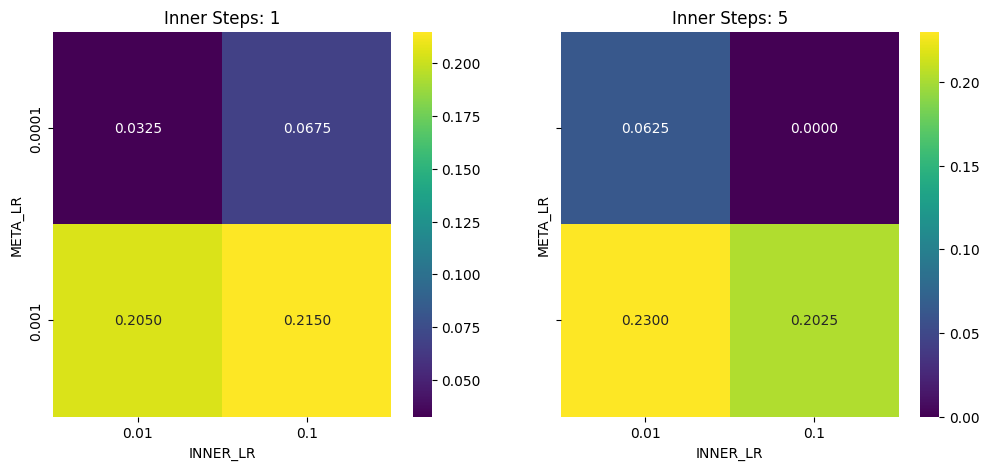


WINNER: MetaLR=0.001, InnerLR=0.01, Steps=5


In [21]:
#################################################################
#  PHASE 5.2: HIGH-PERFORMANCE TUNING (A100 OPTIMIZED)
#################################################################
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

print("\n--- PHASE 5.2: High-Performance Tuning ---")

# --- 1. OPTIMIZED DATA GENERATOR ---
# Wir erweitern den Generator, um 'Chunks' von Tasks zu liefern
class A100TaskGenerator:
    def __init__(self, dataset, ways, shots, query_shots):
        self.dataset = dataset
        self.ways = ways
        self.shots = shots
        self.query_shots = query_shots

        # Caching indices for speed
        self.indices_by_label = {}
        for idx, sample in enumerate(dataset.samples):
            lbl = sample['label']
            if lbl not in self.indices_by_label: self.indices_by_label[lbl] = []
            self.indices_by_label[lbl].append(idx)
        self.classes = list(self.indices_by_label.keys())

    def sample_batch(self, batch_size=32):
        """Generates a whole BATCH of tasks at once to minimize CPU overhead."""
        all_data = []
        all_labels = []

        for _ in range(batch_size):
            selected_classes = random.sample(self.classes, self.ways)
            task_imgs, task_lbls = [], []

            for local_label, global_label in enumerate(selected_classes):
                indices = self.indices_by_label[global_label]
                needed = self.shots + self.query_shots
                # Fast sampling
                selected = random.sample(indices, needed) if len(indices) >= needed else random.choices(indices, k=needed)

                for idx in selected:
                    img, _ = self.dataset[idx]
                    task_imgs.append(img)
                    task_lbls.append(local_label)

            # Stack images for this task: [N_Samples, C, H, W]
            all_data.append(torch.stack(task_imgs))
            all_labels.append(torch.tensor(task_lbls))

        # Return stacked meta-batch: [MetaBatch, N_Samples, C, H, W]
        return torch.stack(all_data), torch.stack(all_labels)

# Wrapper to create the optimized generator
def get_fast_taskset(split, ways=5, shots=5, query_shots=15):
    # Re-use existing MetaINatDataset logic
    train_transforms = transforms.Compose([
        transforms.Resize((84, 84)), # MAML standard size (faster)
        transforms.ToTensor(),
        transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
    ])
    ds = MetaINatDataset(DATASET_ROOT, PARTITION_FILE_PATH, split=split, transform=train_transforms)
    return A100TaskGenerator(ds, ways, shots, query_shots)


# --- 2. OPTIMIZED STEP FUNCTION ---
def tuning_step_optimized(meta_model, task_generator, meta_optimizer, criterion, device, current_cfg, meta_batch_size):
    meta_loss_total = 0.0
    meta_optimizer.zero_grad()

    # 1. FETCH ALL DATA AT ONCE (CPU -> GPU Transfer happens ONCE)
    tasks_data, tasks_labels = task_generator.sample_batch(batch_size=meta_batch_size)
    tasks_data, tasks_labels = tasks_data.to(device), tasks_labels.to(device)

    # Pre-calculate indices
    ways, shots, queries = 5, 5, 15
    support_indices = []
    query_indices = []
    for w in range(ways):
        base = w * (shots + queries)
        support_indices.extend(range(base, base + shots))
        query_indices.extend(range(base + shots, base + shots + queries))

    # 2. LOOP ON GPU (No more CPU waiting)
    for i in range(meta_batch_size):
        # Slicing on GPU is fast
        supp_X = tasks_data[i][support_indices]
        supp_y = tasks_labels[i][support_indices]
        query_X = tasks_data[i][query_indices]
        query_y = tasks_labels[i][query_indices]

        # --- Standard MAML Inner Loop ---
        fast_model = copy.deepcopy(meta_model)
        fast_model.train()
        inner_opt = optim.SGD(fast_model.parameters(), lr=current_cfg['INNER_LR'])

        for _ in range(current_cfg['INNER_STEPS']):
            preds = fast_model(supp_X)
            loss = criterion(preds, supp_y)
            inner_opt.zero_grad()
            loss.backward()
            inner_opt.step()

        q_preds = fast_model(query_X)
        q_loss = criterion(q_preds, query_y)
        meta_loss_total += q_loss.item()
        q_loss.backward()

        # Accumulate Gradients
        for mp, fp in zip(meta_model.parameters(), fast_model.parameters()):
            if fp.grad is not None:
                grad = fp.grad.detach() / meta_batch_size
                if mp.grad is None: mp.grad = grad
                else: mp.grad += grad

        del fast_model, inner_opt # Free VRAM immediately

    meta_optimizer.step()
    return meta_loss_total / meta_batch_size


# --- 3. TUNING CONFIGURATION ---
GRID_SEARCH = {
    'META_LR': [1e-3, 1e-4],
    'INNER_LR': [0.1, 0.01],
    'INNER_STEPS': [1, 5]
}

TUNING_CONFIG = {
    'ARCH': 'resnet34',
    'SUBSET': 0.25,
    'ITERS': 100,       # Weniger Iterationen, da Batch Size größer!
    'META_BATCH': 32,   # <--- HIER IST DER TURBO! (Standard war 4)
    'VAL_INT': 25,
    'DRY_RUN': False
}

if TUNING_CONFIG['DRY_RUN']:
    TUNING_CONFIG['ITERS'] = 2
    TUNING_CONFIG['VAL_INT'] = 1
    TUNING_CONFIG['META_BATCH'] = 2


# --- 4. RUN ENGINE ---
def run_tuning(combo_params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    meta_model = load_base_model_for_maml(TUNING_CONFIG['SUBSET'], TUNING_CONFIG['ARCH'])
    meta_model = meta_model.to(device)
    meta_optimizer = optim.Adam(meta_model.parameters(), lr=combo_params['META_LR'])
    criterion = nn.CrossEntropyLoss()

    # Use optimized generator
    train_gen = get_fast_taskset(split='c_base')
    val_gen = get_fast_taskset(split='c_val') # Reuse for simplicity

    best_acc = 0.0

    pbar = tqdm(range(TUNING_CONFIG['ITERS']), desc="Run", leave=False)
    for i in pbar:
        loss = tuning_step_optimized(meta_model, train_gen, meta_optimizer, criterion, device, combo_params, TUNING_CONFIG['META_BATCH'])
        pbar.set_postfix(loss=f"{loss:.3f}")

        if (i+1) % TUNING_CONFIG['VAL_INT'] == 0:
            # Quick Validation (Zero-Shot Proxy for speed)
            meta_model.eval()
            correct, total = 0, 0
            # Validate on 1 batch of tasks
            v_data, v_lbl = val_gen.sample_batch(4)
            v_data, v_lbl = v_data.to(device), v_lbl.to(device)
            with torch.no_grad():
                # Flatten batch for simple forward pass check
                B, N, C, H, W = v_data.shape
                logits = meta_model(v_data.view(-1, C, H, W))
                targets = v_lbl.view(-1)
                _, preds = torch.max(logits, 1)
                correct += (preds == targets).sum().item()
                total += targets.size(0)
            acc = correct / total
            if acc > best_acc: best_acc = acc
            meta_model.train()

    return best_acc

# --- 5. EXECUTION ---
print(f"Starting A100 Optimized Tuning (Batch Size {TUNING_CONFIG['META_BATCH']})...")
results = []
keys = list(GRID_SEARCH.keys())
combos = list(itertools.product(*GRID_SEARCH.values()))

combo_pbar = tqdm(combos, desc="Total Progress")
for c in combo_pbar:
    params = dict(zip(keys, c))
    try:
        score = run_tuning(params)
        res = params.copy()
        res['Acc'] = score
        results.append(res)
        combo_pbar.write(f" -> {params} | Acc: {score:.4f}")
    except Exception as e:
        print(f"Error: {e}")

# --- 6. RESULTS ---
if results:
    df = pd.DataFrame(results).sort_values(by='Acc', ascending=False)
    print("\n", df)

    # Heatmap logic
    unique_steps = df['INNER_STEPS'].unique()
    fig, axes = plt.subplots(1, len(unique_steps), figsize=(12, 5), sharey=True)
    if len(unique_steps) == 1: axes = [axes]
    for i, steps in enumerate(sorted(unique_steps)):
        ax = axes[i]
        subset = df[df['INNER_STEPS'] == steps]
        pivot = subset.pivot(index='META_LR', columns='INNER_LR', values='Acc')
        sns.heatmap(pivot, annot=True, fmt=".4f", cmap="viridis", ax=ax)
        ax.set_title(f"Inner Steps: {steps}")
    plt.show()

    win = df.iloc[0]
    print(f"\nWINNER: MetaLR={win['META_LR']}, InnerLR={win['INNER_LR']}, Steps={int(win['INNER_STEPS'])}")